In [ ]:
!git clone https://github.com/alaminhossain01615/emotion_detection.git

Cloning into 'emotion_detection'...
remote: Enumerating objects: 34189, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 34189 (delta 61), reused 99 (delta 36), pack-reused 34061 (from 2)
Receiving objects: 100% (34189/34189), 52.47 MiB | 13.58 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Updating files: 100% (35899/35899), done.


In [ ]:
%cd emotion_detection/
!git pull

[Errno 2] No such file or directory: 'emotion_detection/'
/content/emotion_detection
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 393 bytes | 393.00 KiB/s, done.
From https://github.com/alaminhossain01615/emotion_detection
   0516cea9..1c30dab8  master     -> origin/master
Updating 0516cea9..1c30dab8
Fast-forward
 src/data/rasnet18.py | 5 ++---
 1 file changed, 2 insertions(+), 3 deletions(-)


In [1]:
import os
import sys
repo_name = 'emotion_detection'

repo_path = os.path.join('/content', repo_name)

if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")
print("Dataset downloaded to:", path)

ModuleNotFoundError: No module named 'kagglehub'


--- Dataset Summary ---
Total Classes Found: 7
Total Images Found: 28709

Class-wise Image Counts:
- **angry**: 3995 images
- **disgust**: 436 images
- **fear**: 4097 images
- **happy**: 7215 images
- **neutral**: 4965 images
- **sad**: 4830 images
- **surprise**: 3171 images

Data Imbalance Ratio (Max/Min): 16.55


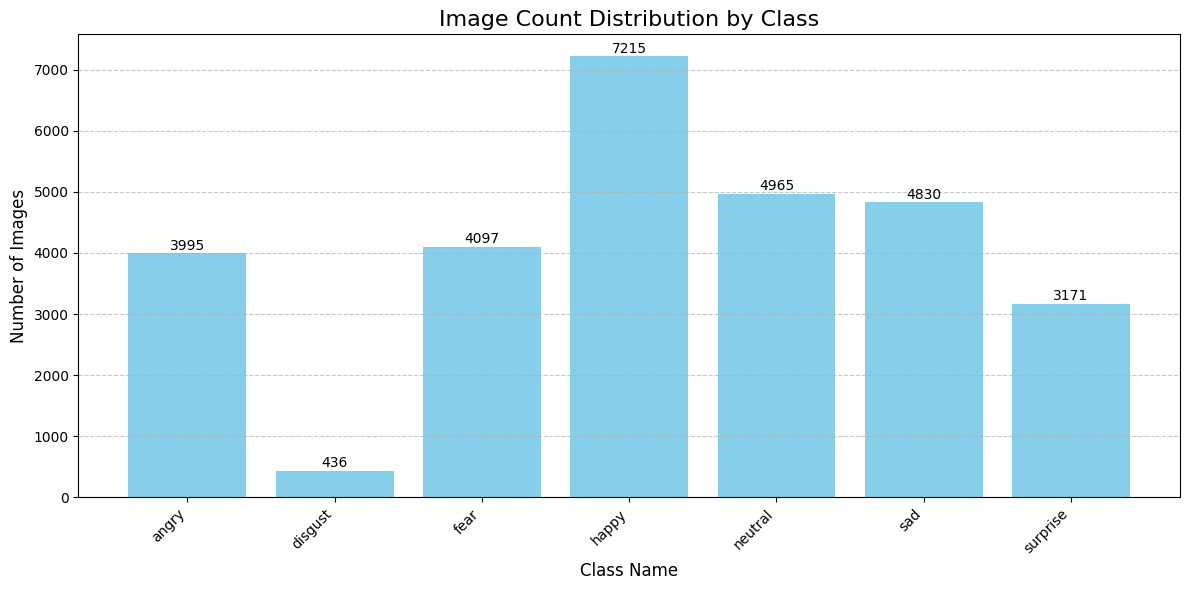


Plot displayed.


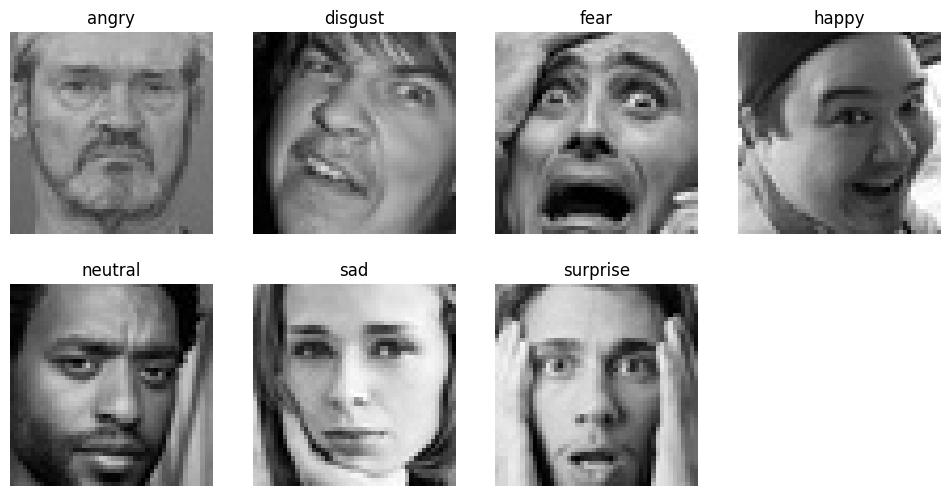

In [3]:
import importlib
import src.data.fer_dataset
importlib.reload(src.data.fer_dataset)
from src.data.fer_dataset import ImageDatasetExplorer

TRAIN_DATASET_ROOT = 'archive/train'
TEST_DATASET_ROOT = 'archive/test'
explorer = ImageDatasetExplorer(TRAIN_DATASET_ROOT)
explorer.explore_data()
explorer.plot_class_distribution()
explorer.display_some_random_samples()

tensor([0.5038]) tensor([0.2534])


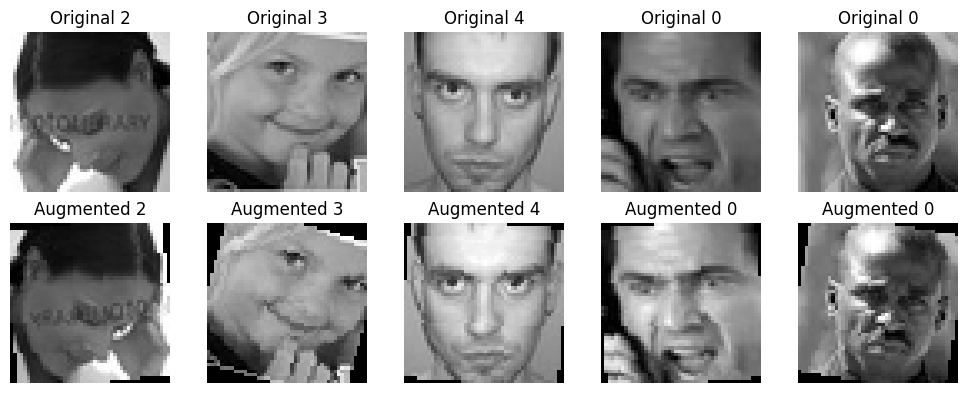

In [4]:
import src.data.data_preprocessing
importlib.reload(src.data.data_preprocessing)
from src.data.data_preprocessing import DataPreprocessing

process = DataPreprocessing(TRAIN_DATASET_ROOT)
mean,std = process.calculate_mean_and_std()
print(mean,std)

train_transformation = process.augment_and_transform_data()

In [7]:
import torch
print(torch.__version__)

2.5.1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import src.data.Training
importlib.reload(src.data.Training)
from src.data.mlp import MLP_network
from src.data.Training import Training
from src.data.Evaluate import Evaluate
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

list_of_transform_pipeline=[ v2.ToImage(),v2.Grayscale(num_output_channels=1),v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean,std=std)]
train_transformation = process.augment_and_transform_data(plot_original_vs_augmented=0)
test_transformation = process.augment_and_transform_data(list_of_transform_pipeline=list_of_transform_pipeline,plot_original_vs_augmented=0)
train_dataset=ImageFolder(TRAIN_DATASET_ROOT,transform=train_transformation)
train_loader=DataLoader(train_dataset,batch_size=512,shuffle=True)

test_dataset=ImageFolder(TEST_DATASET_ROOT,transform=test_transformation)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not detected, using CPU.")

model_mlp=MLP_network().to(device)
SAVE_PATH='content/saved_model/best_mlp.pth'
optimizer=optimizer=optim.Adam(model_mlp.parameters(),lr=1e-03)
loss_func=nn.CrossEntropyLoss()

trainer=Training(model=model_mlp,optimizer=optimizer,loss_func=loss_func,device=device,save_path=SAVE_PATH)
history_mlp=trainer.train_model(train_loader,test_loader,150)

Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU
---Training----


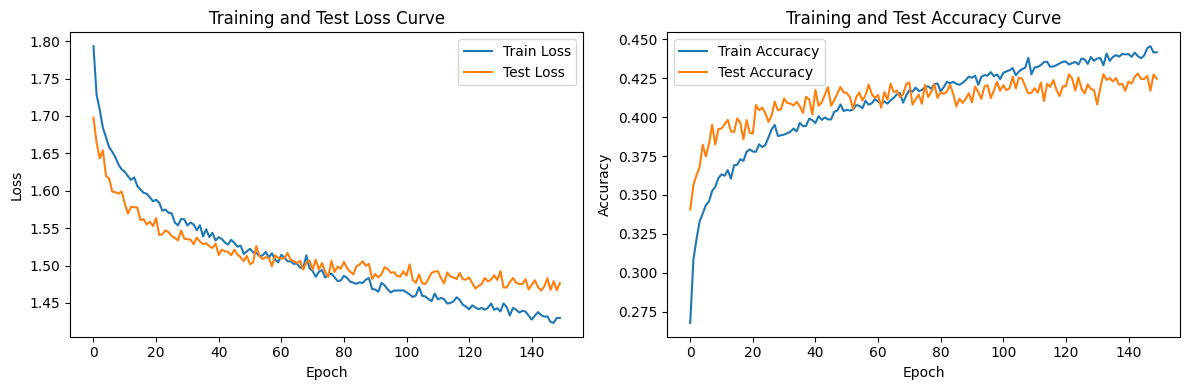


---Confusion Matrix---


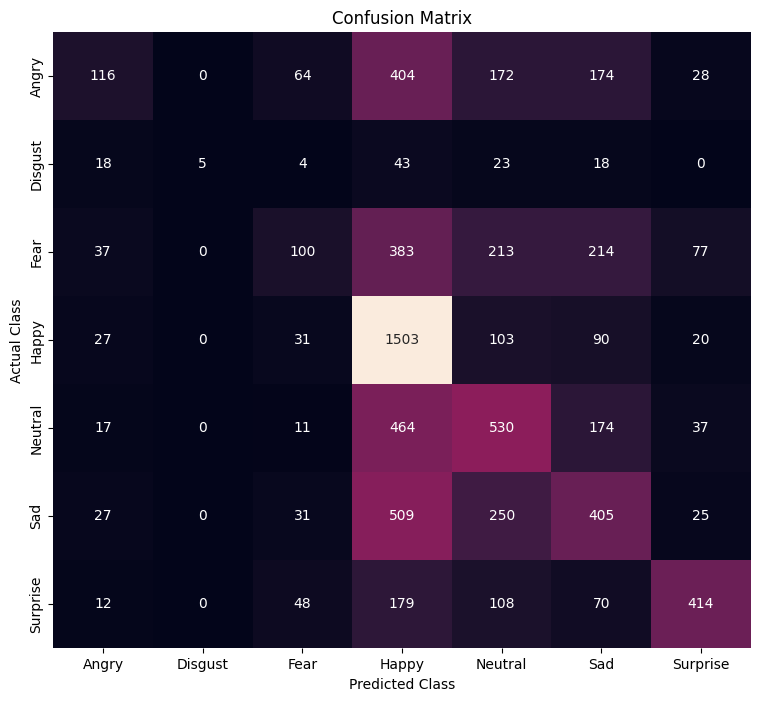

In [ ]:
best_model=MLP_network().to(device)
best_model.load_state_dict(torch.load('/content/saved_model/best_mlp.pth', map_location=device))
evaluate = Evaluate(best_model, device)
evaluate.plot_history(history_mlp)
evaluate.plot_confusion_matrix(test_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.data.cnn import CNN_network
from src.data.Training import Training
from src.data.Evaluate import Evaluate
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

list_of_transform_pipeline=[ v2.ToImage(),v2.Grayscale(num_output_channels=1),v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean,std=std)]
train_transformation = process.augment_and_transform_data(plot_original_vs_augmented=0)
test_transformation = process.augment_and_transform_data(list_of_transform_pipeline=list_of_transform_pipeline,plot_original_vs_augmented=0)
train_dataset=ImageFolder(TRAIN_DATASET_ROOT,transform=train_transformation)
train_loader=DataLoader(train_dataset,batch_size=512,shuffle=True)

test_dataset=ImageFolder(TEST_DATASET_ROOT,transform=test_transformation)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
model_cnn=CNN_network().to(device)
SAVE_PATH='/content/saved_model/best_cnn.pth'
optimizer=optimizer=optim.Adam(model_cnn.parameters(),lr=1e-03)
loss_func=nn.CrossEntropyLoss()

trainer=Training(model=model_cnn,optimizer=optimizer,loss_func=loss_func,device=device,save_path=SAVE_PATH)
history_cnn=trainer.train_model(train_loader,test_loader,70)

Using cuda device
---Training----
Epoch 1 --- train_loss 1.757761485458122, train_acc 0.2736424117872444 --- test_loss 1.658153617372085, test_acc 0.3439676790192254
---Training----
Epoch 2 --- train_loss 1.6205491479601064, train_acc 0.36438050785467974 --- test_loss 1.5253936263570949, test_acc 0.4102814154360546
---Training----
Epoch 3 --- train_loss 1.5223731472805386, train_acc 0.4151311435438364 --- test_loss 1.41924017187811, test_acc 0.4543048202842017
---Training----
Epoch 4 --- train_loss 1.4528011605634041, train_acc 0.4423003239402278 --- test_loss 1.3742931806532976, test_acc 0.47826692672053495
---Training----
Epoch 5 --- train_loss 1.3950353179415955, train_acc 0.46633459890626633 --- test_loss 1.3199288277248713, test_acc 0.4882975759264419
---Training----
Epoch 6 --- train_loss 1.3568758720007763, train_acc 0.4796753631265457 --- test_loss 1.3013972133173854, test_acc 0.5009752020061299
---Training----
Epoch 7 --- train_loss 1.3220139511318607, train_acc 0.498136472883

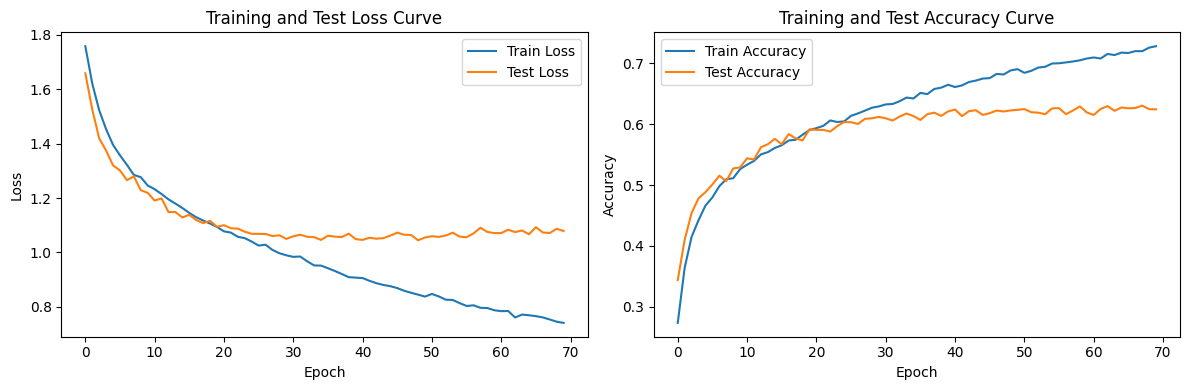


---Confusion Matrix---


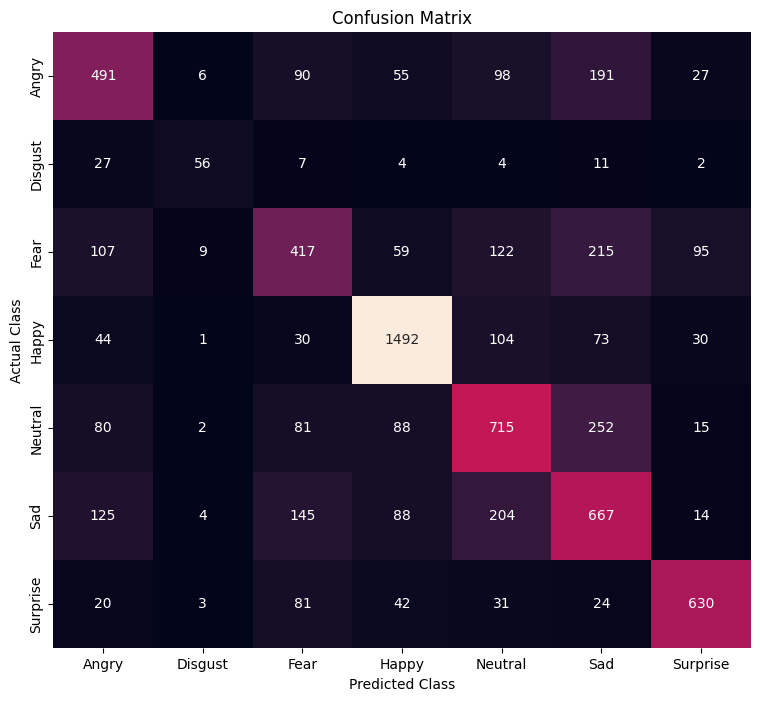

In [ ]:
best_model=CNN_network().to(device)
best_model.load_state_dict(torch.load('/content/saved_model/best_cnn.pth', map_location=device))
evaluate = Evaluate(best_model, device)
evaluate.plot_history(history_cnn)
evaluate.plot_confusion_matrix(test_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import src.data.rasnet18
importlib.reload(src.data.rasnet18)
from src.data.rasnet18 import Rasnet18
from src.data.Training import Training
from src.data.Evaluate import Evaluate
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

list_of_transform_pipeline=[ v2.ToImage(),v2.Grayscale(num_output_channels=1),v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean,std=std)]
train_transformation = process.augment_and_transform_data(plot_original_vs_augmented=0)
test_transformation = process.augment_and_transform_data(list_of_transform_pipeline=list_of_transform_pipeline,plot_original_vs_augmented=0)
train_dataset=ImageFolder(TRAIN_DATASET_ROOT,transform=train_transformation)
train_loader=DataLoader(train_dataset,batch_size=512,shuffle=True)

test_dataset=ImageFolder(TEST_DATASET_ROOT,transform=test_transformation)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not detected, using CPU.")
rsnt=Rasnet18()
model_rasnet = rsnt.get_custom_rasnet(use_pretrained=1).to(device)
SAVE_PATH='content/saved_model/best_rsnt.pth'
optimizer=optimizer=optim.Adam(model_rasnet.parameters(),lr=1e-03)
loss_func=nn.CrossEntropyLoss()

trainer=Training(model=model_rasnet,optimizer=optimizer,loss_func=loss_func,device=device,save_path=SAVE_PATH)
history_cnn=trainer.train_model(train_loader,test_loader,50)

Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\alami/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


---Training----


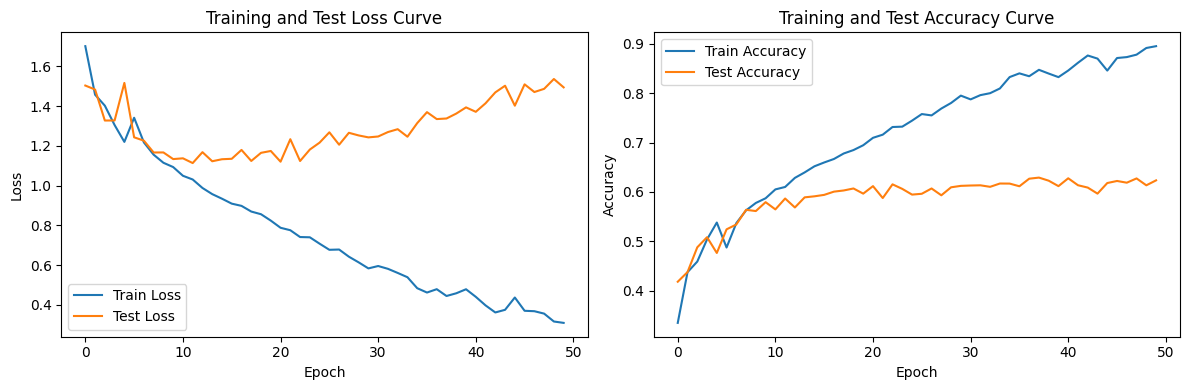


---Confusion Matrix---


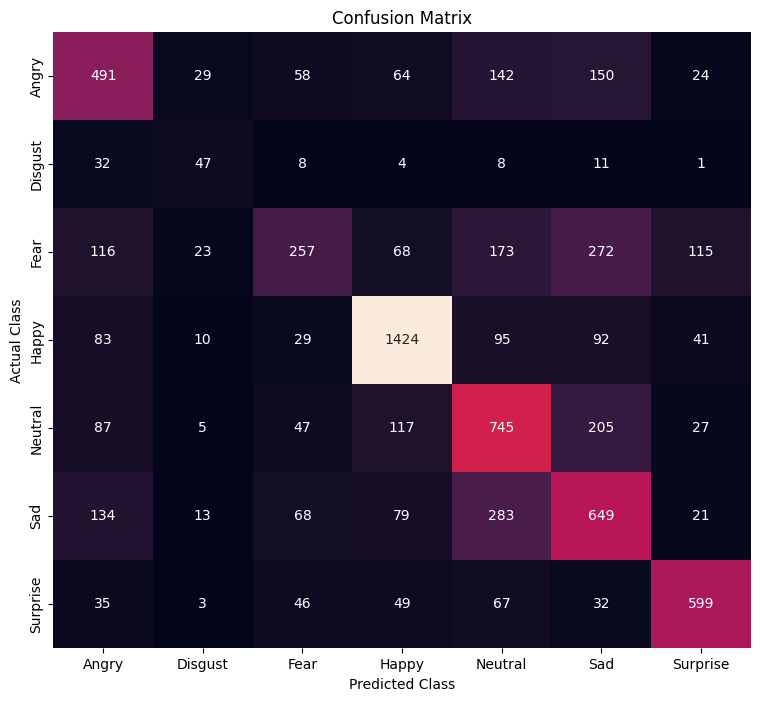

In [ ]:
best_model=rsnt.get_custom_rasnet().to(device)
best_model.load_state_dict(torch.load('/content/saved_model/best_rsnt.pth', map_location=device))
evaluate = Evaluate(best_model, device)
evaluate.plot_history(history_cnn)
evaluate.plot_confusion_matrix(test_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import src.data.rasnet18
importlib.reload(src.data.rasnet18)
from src.data.rasnet18 import Rasnet18
from src.data.Training import Training
from src.data.Evaluate import Evaluate
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

list_of_transform_pipeline=[ v2.ToImage(),v2.Grayscale(num_output_channels=1),v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean,std=std)]
train_transformation = process.augment_and_transform_data(plot_original_vs_augmented=0)
test_transformation = process.augment_and_transform_data(list_of_transform_pipeline=list_of_transform_pipeline,plot_original_vs_augmented=0)
train_dataset=ImageFolder(TRAIN_DATASET_ROOT,transform=train_transformation)
train_loader=DataLoader(train_dataset,batch_size=512,shuffle=True)

test_dataset=ImageFolder(TEST_DATASET_ROOT,transform=test_transformation)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
rsnt=Rasnet18()
model_rasnet = rsnt.get_custom_rasnet(use_pretrained=0).to(device)
SAVE_PATH='/content/saved_model/best_rsnt1.pth'
optimizer=optimizer=optim.Adam(model_rasnet.parameters(),lr=1e-03)
loss_func=nn.CrossEntropyLoss()

trainer=Training(model=model_rasnet,optimizer=optimizer,loss_func=loss_func,device=device,save_path=SAVE_PATH)
history_cnn=trainer.train_model(train_loader,test_loader,50)

Using cuda device
---Training----
Epoch 1 --- train_loss 1.634016737419218, train_acc 0.3570657285171897 --- test_loss 1.4953665065712236, test_acc 0.4246308163833937
---Training----
Epoch 2 --- train_loss 1.4315127480087777, train_acc 0.44543522937058067 --- test_loss 1.3757630637775526, test_acc 0.46753970465310674
---Training----
Epoch 3 --- train_loss 1.335419550639276, train_acc 0.4867463164861193 --- test_loss 1.3464899710806408, test_acc 0.49080523822791866
---Training----
Epoch 4 --- train_loss 1.2818256564854356, train_acc 0.5086558222160298 --- test_loss 1.2385441511578799, test_acc 0.5218723878517693
---Training----
Epoch 5 --- train_loss 1.2229047673154414, train_acc 0.5325507680518304 --- test_loss 1.2603078227117555, test_acc 0.5157425466703818
---Training----
Epoch 6 --- train_loss 1.1781711647297846, train_acc 0.5493399282454979 --- test_loss 1.2262326330818416, test_acc 0.5249373084424631
---Training----
Epoch 7 --- train_loss 1.1374324072640145, train_acc 0.5719112473

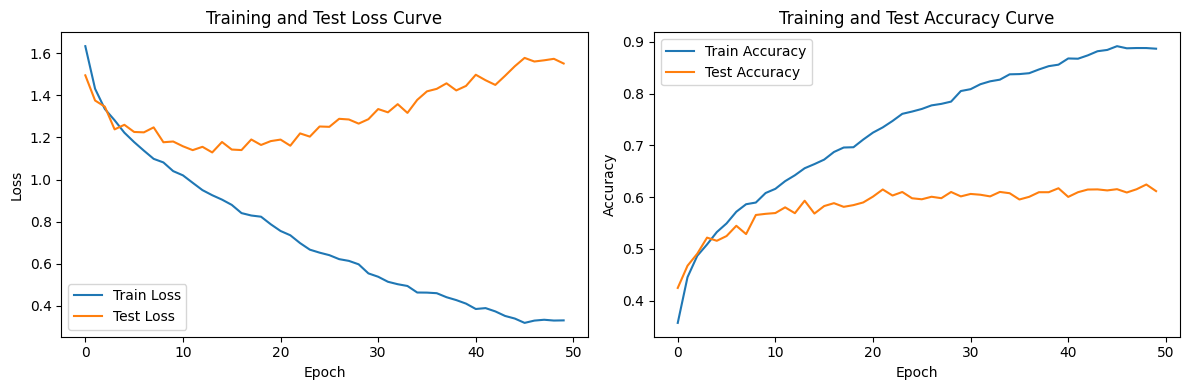


---Confusion Matrix---


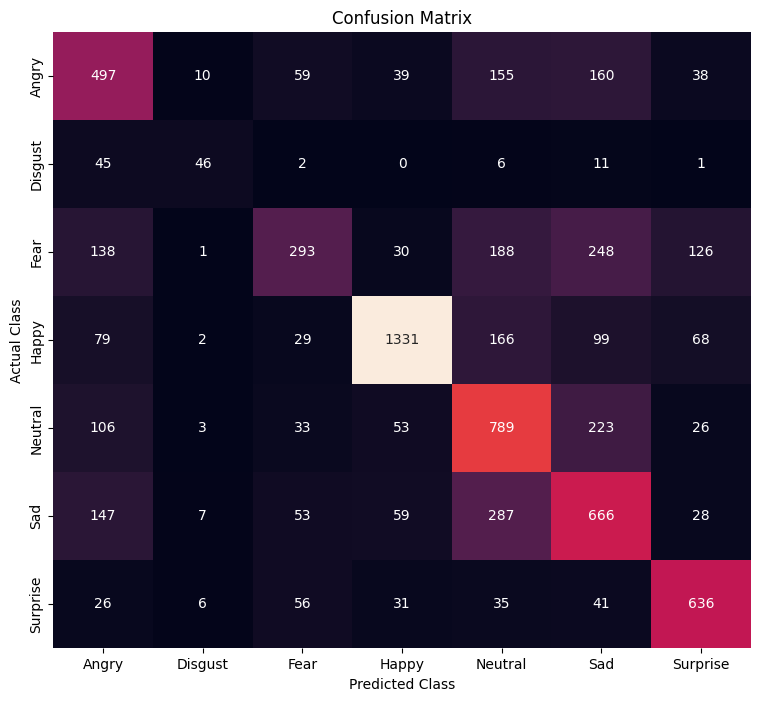

In [ ]:
best_model=rsnt.get_custom_rasnet().to(device)
best_model.load_state_dict(torch.load('/content/saved_model/best_rsnt1.pth', map_location=device))
evaluate = Evaluate(best_model, device)
evaluate.plot_history(history_cnn)
evaluate.plot_confusion_matrix(test_loader)

In [ ]:
def get_custom_rasnet(input_channels=1,num_classes=7,use_pretrained=1):
  if use_pretrained:
      model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
      with torch.no_grad():
          old_weights = model.conv1.weight.clone()
          model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=3, bias=False)
          model.conv1.weight = nn.Parameter(old_weights.mean(dim=1, keepdim=True))
  else:
      model = models.resnet18(weights=None)
      model.conv1 = nn.Conv2d(input_channels,64,kernel_size=7,stride=2,padding=3,bias=False)

  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, num_classes)
  return model

In [ ]:
model=get_custom_rasnet().to(device)

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
SAVE_PATH='/content/saved_model/best_rsnt2.pth'
optimizer=optimizer=optim.Adam(model.parameters(),lr=1e-03)
loss_func=nn.CrossEntropyLoss()

trainer=Training(model=model,optimizer=optimizer,loss_func=loss_func,device=device,save_path=SAVE_PATH)
history_cnn=trainer.train_model(train_loader,test_loader,50)

---Training----
Epoch 1 --- train_loss 1.4819523959977197, train_acc 0.4413250200285625 --- test_loss 1.3094583667397466, test_acc 0.49233769852326553
---Training----
Epoch 2 --- train_loss 1.1904520113069796, train_acc 0.5458915322721097 --- test_loss 1.1651047717133216, test_acc 0.5633881303984397
---Training----
Epoch 3 --- train_loss 1.12588086690336, train_acc 0.5740360165801665 --- test_loss 1.230672492011738, test_acc 0.548760100306492
---Training----
Epoch 4 --- train_loss 1.0603345619846967, train_acc 0.5999860670869762 --- test_loss 1.1077647467457041, test_acc 0.5957091111730287
---Training----
Epoch 5 --- train_loss 1.017592349696539, train_acc 0.61701905325856 --- test_loss 1.1188773898219424, test_acc 0.5881861242685985
---Training----
Epoch 6 --- train_loss 0.9979538650297438, train_acc 0.6239506774878958 --- test_loss 1.12623218185608, test_acc 0.5893006408470326
---Training----
Epoch 7 --- train_loss 0.9499530584557461, train_acc 0.6413319864850744 --- test_loss 1.0883